In [1]:
import os
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
os.environ["KERAS_BACKEND"] = "torch"
import keras
from datamodules import data_processors
import sys
print(sys.version)

3.13.1 (main, Dec  9 2024, 00:00:00) [GCC 14.2.1 20240912 (Red Hat 14.2.1-3)]


In [2]:
N_archivos = 7
path_rand = map(lambda x: "../input_data/cubic_" + str(x + 1) + ".csv", range(N_archivos))
datos_rand = [pd.read_csv(x) for x in path_rand]
path_to_current_model = "none" #"models/isotropico_act_custom_6.keras" # colocar "none" si quiere entrenar un modelo

In [3]:
datos_rand[0].head()

,phi_a,x_K,eta,beta,phi_K,eig_0,eig_1,eig_2,eig_3,eig_4,...,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19,Parallelepiped,Cylinder,Ellipsoid
0,0.843666,0.647473,1.577259,1.574131,0.866533,0.552390,2.341186,2.982731,4.346947,4.543615,...,10.255629,10.934964,12.169362,12.639375,13.023291,17.260278,18.912029,1,0,0
1,0.618911,0.218057,1.216162,1.820191,1.350973,0.451902,1.069440,2.198825,3.912317,3.934114,...,11.230938,11.241764,11.468446,14.561622,14.919805,15.338283,15.666733,1,0,0
2,0.076877,0.245986,1.434582,2.036289,1.322259,0.104398,3.832743,4.758215,5.732612,5.807000,...,15.088024,15.429422,16.241738,16.394792,20.165109,25.500514,26.305482,1,0,0
3,1.459619,0.517388,1.481719,1.376496,1.027000,0.202136,2.142934,2.641222,2.779140,3.088002,...,10.969815,12.756643,13.922951,14.045571,15.047647,18.770442,19.392401,1,0,0
4,0.032508,0.949501,1.839938,0.803203,0.319154,0.002714,10.061990,13.963490,14.997477,17.405756,...,56.063736,70.470168,72.668095,76.780522,93.416045,97.561829,106.012724,1,0,0


In [4]:
N_eig = 19
features = ["eta", "beta"] + list(map(lambda x: "eig_" + str(x+1), range(N_eig)))
target = ["phi_a", "phi_K"]

In [5]:
datos_post = []
for datos in datos_rand:
    datos_post.append(data_processors.preprocess_data(datos, N_eig, target))
#fin for 
datos_rand = datos_post

In [6]:
datos_rand[0].head()

,phi_a,phi_K,eig_0,eta,beta,eig_1,eig_2,eig_3,eig_4,eig_5,...,eig_10,eig_11,eig_12,eig_13,eig_14,eig_15,eig_16,eig_17,eig_18,eig_19
0,0.537095,0.551652,0.552390,1.577259,1.574131,0.427134,0.784913,0.686167,0.956716,0.970898,...,0.904775,0.992303,0.881906,0.979288,0.937875,0.898565,0.962814,0.970521,0.754524,0.912661
1,0.394011,0.860056,0.451902,1.216162,1.820191,0.935069,0.486369,0.562026,0.994460,0.833391,...,0.932846,0.962241,0.798270,0.981873,0.999037,0.980234,0.787580,0.975993,0.972717,0.979035
2,0.048942,0.841777,0.104398,1.434582,2.036289,0.260910,0.805500,0.830026,0.987190,0.736554,...,0.940372,0.838139,0.860529,0.988293,0.977874,0.949986,0.990665,0.813028,0.790773,0.969399
3,0.929222,0.653809,0.202136,1.481719,1.376496,0.466650,0.811342,0.950374,0.899980,0.743699,...,0.948353,0.986246,0.892242,0.916474,0.859930,0.916231,0.991270,0.933406,0.801667,0.967928
4,0.020696,0.203180,0.002714,1.839938,0.803203,0.099384,0.720593,0.931056,0.861639,0.698142,...,0.844977,0.995644,0.762149,0.972850,0.795567,0.969754,0.946439,0.821920,0.957506,0.920284


In [7]:
X_rand = [datos_rand[x][features] for x in range(N_archivos)]
y_rand = [datos_rand[x][target] for x in range(N_archivos)]

In [8]:
X_train = pd.concat((X_rand[i] for i in range(5)), axis = 0)
y_train = pd.concat((y_rand[i] for i in range(5)), axis = 0)

In [9]:
corr_mat = X_train.select_dtypes(include=['number']).corr()
print(corr_mat)

             eta      beta     eig_1     eig_2     eig_3     eig_4     eig_5  \
eta     1.000000 -0.000897  0.153405  0.352221  0.358334  0.471363  0.254720   
beta   -0.000897  1.000000  0.401896  0.394072  0.108164  0.159199  0.434086   
eig_1   0.153405  0.401896  1.000000 -0.194175 -0.064278  0.140901  0.230196   
eig_2   0.352221  0.394072 -0.194175  1.000000 -0.089491  0.206108  0.333111   
eig_3   0.358334  0.108164 -0.064278 -0.089491  1.000000 -0.067755  0.031207   
eig_4   0.471363  0.159199  0.140901  0.206108 -0.067755  1.000000 -0.001042   
eig_5   0.254720  0.434086  0.230196  0.333111  0.031207 -0.001042  1.000000   
eig_6   0.401341  0.179475  0.113264  0.237715  0.180509  0.196401  0.089357   
eig_7   0.393098  0.040264  0.073610  0.036482  0.306994  0.163555 -0.018017   
eig_8   0.316567  0.255060  0.232821  0.205350  0.082370  0.277743  0.188956   
eig_9   0.430568  0.257193  0.128147  0.353725  0.116459  0.276586  0.296052   
eig_10  0.372412  0.200724  0.100527  0.

Text(0.5, 1.0, 'Correlation Matrix')

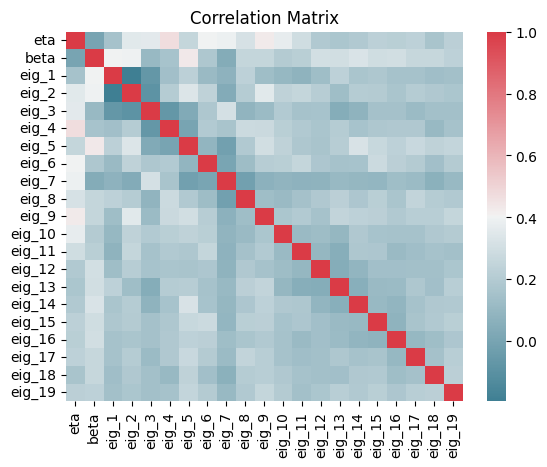

In [10]:
sns.heatmap(corr_mat, cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.title("Correlation Matrix")

In [11]:
torch.cuda.get_device_properties(torch.device("cuda"))

_CudaDeviceProperties(name='AMD Radeon RX 6600M', major=10, minor=3, gcnArchName='gfx1030', total_memory=8176MB, multi_processor_count=14, uuid=58580000-0000-0000-0000-000000000000, L2_cache_size=2MB)

In [12]:
n_pow = 20
def custom_activation(x):
    return (1/n_pow) * torch.log((1 + torch.exp(n_pow * x)) / (1 + torch.exp(n_pow * (x - 1))))
#fin función

# Wrap the function in a Keras custom layer
@keras.saving.register_keras_serializable()
class CustomActivationLayer(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(CustomActivationLayer, self).__init__(**kwargs)
    
    def call(self, inputs):
        # Ensure inputs are Torch tensors
        inputs = torch.tensor(inputs) if not isinstance(inputs, torch.Tensor) else inputs
        return custom_activation(inputs)
    #fin función
#fin clase

#act = keras.activations.leaky_relu()

def crear_modelo_de_regresion(lr_var, n_input_data):    
    modelo = keras.models.Sequential()
    modelo.add(keras.layers.Dense(128, activation = 'leaky_relu', input_shape = (n_input_data,)))
    modelo.add(keras.layers.Dense(512, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(752, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(1245, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(2436, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(1652, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(987, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(620, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(256, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(128, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(8, activation = 'leaky_relu'))
    modelo.add(keras.layers.Dense(2))
    modelo.add(CustomActivationLayer())
    modelo.compile(optimizer = keras.optimizers.RMSprop(learning_rate = lr_var), loss = 'mse', metrics = ['mae']) #RMSprop
    return modelo

In [13]:
k = 4 #4 sets de validación
n_muestras_val = len(X_train) // k
epocas = 20
all_history = []

In [14]:
if path_to_current_model == "none":
    modelo = crear_modelo_de_regresion(0.0005, len(features))
    history = modelo.fit(X_train, y_train, epochs = epocas, batch_size=16, 
                            validation_data = (X_rand[5], y_rand[5]))
else:
    modelo = keras.models.load_model(path_to_current_model)
#fin if 

/home/cubos/.local/lib/python3.13/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/home/cubos/.local/lib/python3.13/site-packages/keras/src/backend/torch/numpy.py:114: UserWarning: Attempting to use hipBLASLt on an unsupported architecture! Overriding blas backend to hipblas (Triggered internally at /pytorch/aten/src/ATen/Context.cpp:328.)
  return cast(torch.matmul(x1, x2), result_dtype)


15623/15623 ━━━━━━━━━━━━━━━━━━━━ 262s 17ms/step - loss: 0.0481 - mae: 0.1729 - val_loss: 0.0312 - val_mae: 0.1333
Epoch 2/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 263s 17ms/step - loss: 0.0312 - mae: 0.1320 - val_loss: 0.0294 - val_mae: 0.1274
Epoch 3/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 262s 17ms/step - loss: 0.0281 - mae: 0.1223 - val_loss: 0.0264 - val_mae: 0.1177
Epoch 4/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 262s 17ms/step - loss: 0.0257 - mae: 0.1150 - val_loss: 0.0231 - val_mae: 0.1082
Epoch 5/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 263s 17ms/step - loss: 0.0240 - mae: 0.1095 - val_loss: 0.0228 - val_mae: 0.1042
Epoch 6/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 260s 17ms/step - loss: 0.0227 - mae: 0.1055 - val_loss: 0.0230 - val_mae: 0.1069
Epoch 7/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 262s 17ms/step - loss: 0.0217 - mae: 0.1023 - val_loss: 0.0215 - val_mae: 0.1022
Epoch 8/20
15623/15623 ━━━━━━━━━━━━━━━━━━━━ 262s 17ms/step - loss: 0.0207 - mae: 0.0991 - val_loss: 0.0194 - val_mae: 0.0944
Epoch 9/20


In [15]:
mets_train = data_processors.get_metrics(X_train, y_train, modelo)
mets_val = data_processors.get_metrics(X_rand[5], y_rand[5], modelo)
mets_rand1 = data_processors.get_metrics(X_rand[6], y_rand[6], modelo)

7812/7812 ━━━━━━━━━━━━━━━━━━━━ 36s 5ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step


In [16]:
print("Train: ", mets_train)
print("Val: ", mets_val)
print("Test: ", mets_rand1)

Train:  {'R2': 0.7204395532608032, 'RMSE': 0.1200738251209259, 'MAE': 0.08574890345335007, 'SDAE': np.float64(0.23058875514297608)}
Val:  {'R2': 0.7052351236343384, 'RMSE': 0.12330493330955505, 'MAE': 0.08782292157411575, 'SDAE': np.float64(0.23031351594503005)}
Test:  {'R2': 0.7051550149917603, 'RMSE': 0.1235344260931015, 'MAE': 0.08795429766178131, 'SDAE': np.float64(0.23090860848053374)}


In [17]:
if path_to_current_model == "none":
    modelo.save("models/cubico_2.keras")
#fin if 

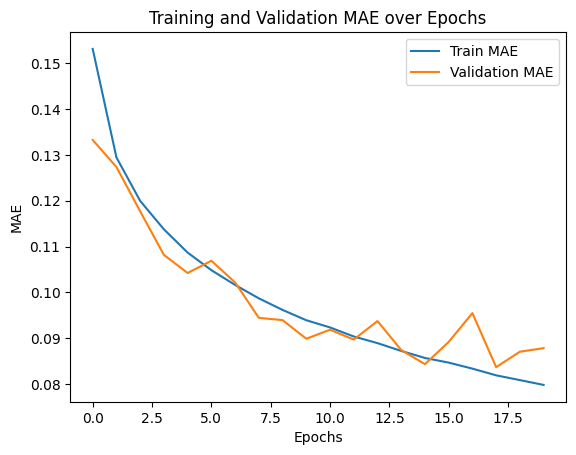

In [18]:
if path_to_current_model == "none":
    train_mae = history.history["mae"]
    val_mae = history.history["val_mae"]
    plt.figure()
    plt.plot(train_mae, label='Train MAE')
    plt.plot(val_mae, label='Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.title('Training and Validation MAE over Epochs')
    plt.legend()

In [19]:
if path_to_current_model == "none":
    import json
    with open('models/cubic_history_2.json', 'w') as f:
        json.dump(history.history, f)